 # Disentangling the cognitive, physical, and mental health sequalae of COVID-19.
 ### Conor J. Wild*, Loretta Norton, David K. Menon, David A. Ripsman, Richard H. Swartz, & Adrian M. Owen
 #### Corresponding Author: cwild@uwo.ca, conorwild@gmail.com

In [37]:
# Standard libraries
from IPython.core.display import display_svg
import pandas as pd
import numpy as np

from scipy.linalg import pinv
from scipy.stats import probplot # for QQ-plots
import statsmodels.formula.api as smf

# For data transformations
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import \
	StandardScaler, \
	OneHotEncoder, \
	MinMaxScaler, \
	PowerTransformer
from sklearn.compose import ColumnTransformer

from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import \
	calculate_bartlett_sphericity, \
	calculate_kmo

# Custom tools for working with CBS data.
# Non-vital stuff like names of tests, etc.
import covid_cognition.lib_cbs as cbs		

# Custom functions and helpers for doing stats, plots, etc.
# These are located alongside this script.
import covid_cognition.lib_stats as ws
import covid_cognition.lib_plots as wp
import covid_cognition.lib_colours as wc
from covid_cognition.lib_chord import chord_plot
from covid_cognition.lib_utils import \
	report_N, remove_unused_categories, set_column_names, \
	save_and_display_figure, save_and_display_table, tuckersCC

# Helper packages that load the study data.
from cbs_data.covid_cognition import CovidCognition as CC
from cbs_data.control_study import ControlStudy as CS # this is the CTRL dataset

# Plotly for plotting
import plotly
import plotly.express as px
import importlib
from IPython.display import SVG, display

# Display options for in this notebook
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
np.set_printoptions(precision=3)

idx = pd.IndexSlice

 ## Control (Pre-Pandemic) Dataset
 ### Load & Preprocess Data

In [38]:
# Loads the control dataset from the (private) SS library
Yctrl = CS.score_data

# List columns corresponding to "timing" (RT) features
tf  = cbs.timing_features(exclude=['spatial_planning']) # SP does not have one
tf_ = cbs.abbrev_features(tf)		# Abbreviated name

# List of columns corresponding to score features used in domain score calcs.
df  = cbs.domain_feature_list()
df_ = cbs.abbrev_features(df)

# A list of "all" available score features
af  = list(Yctrl.columns)
af_ = cbs.abbrev_features(af)
				
# From Hampshire et al. 2012, and Wild et al. These are the variables that are
# related to performance on these cognitive tasks.
Xcovar = ['age', 'sex', 'post_secondary', 'SES', 'exercise',
	'nicotine', 'alcohol', 'cannabis', 'stimulants', 'depressants']

# Loads the control dataset (Sleep Study, 2017)
print("\nControl Scores:")
Yctrl = (Yctrl
	.pipe(set_column_names, af_)
	.reset_index('device_type')
	.pipe(report_N, "initial dataset", reset_count=True)
	.query('~(device_type in ["BOT", "CONSOLE", "MOBILE"])')
	.pipe(report_N, "drop unsupported devices")
	.reset_index().astype({'user': str})
	.set_index('user')
)

# Loads and organises the control questionnaire dataset
# Have to rename a few columns to match them up to the new study data
print("\nControl Questionnaires:")
Qctrl = (CS
	.questionnaire.data
	.reset_index().astype({'user': str})
	.set_index('user')
	.rename(columns={'SES_growing_up': 'SES'})
	.assign(post_secondary = lambda x: x.education >= "Bachelor's Degree")
	.assign(nicotine = lambda x: x.cigarettes_per_day > 0)
	.assign(alcohol = lambda x: x.alcohol_per_week > 14)
	.assign(exercise = lambda x: x.exercise_freq >= 'Once or twice a week')
	.pipe(report_N, "initial dataset", reset_count=True)
)

# Join the test scores (Yctrl) and the questionnaire data (Qctrl), then
# filter score columns to remove outliers (6 then 4 stdevs)
print("\nControl Dataset:")
Zctrl = (Yctrl
	.join(Qctrl[Xcovar], how='inner')
	.pipe(report_N, 'join datasets', reset_count=True)
	.query('(age >= 18) & (age <= 100)')
	.query('sex in ["Male", "Female"]')
	.pipe(report_N, 'filter age')
	.pipe(report_N, 'English only')
	.dropna(subset=Xcovar+af_)
	.pipe(report_N, 'drop missing data')
	.pipe(ws.filter_df, subset=af_, sds=[6], drop=True)
	.pipe(report_N, '6 SD filter')
	.pipe(ws.filter_df, subset=af_, sds=[4], drop=True)
	.pipe(report_N, '4 SD filter')
	.dropna()
	.pipe(remove_unused_categories)
	.pipe(report_N, 'final')
)

# We'll use these in a table.
Ystats_ctrl  = Zctrl[af_].agg(['mean', 'std'])

# Calculate mean and stdev for the score features, and remember them so we can 
# later apply these transformations to the test (CC) dataset.
Ytfm = Pipeline(steps=[
	('center', StandardScaler(with_mean=True, with_std=True)),
	('yeo', PowerTransformer(method='yeo-johnson'))
]).fit(Zctrl[af_].values)

# Z-scores the control test scores (all features)
Zctrl[af_] = Ytfm.transform(Zctrl[af_].values)


Control Scores:
N = 18424, +18424 (initial dataset)
N = 18424,     +0 (drop unsupported devices)

Control Questionnaires:
N = 36538, +36538 (initial dataset)

Control Dataset:
N = 18423, +18423 (join datasets)
N = 16592,  -1831 (filter age)
N = 16592,     +0 (English only)
N =  8998,  -7594 (drop missing data)
N =  8709,   -289 (6 SD filter)
N =  7832,   -877 (4 SD filter)
N =  7832,     +0 (final)


 ### Factor Analysis (PCA) of CBS Test Scores (Control Group)

/Users/conorwild/.pyenv/versions/3.7.9/envs/cbspython-3.7/lib/python3.7/site-packages/sklearn/utils/extmath.py:376: FutureWarning:

If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.



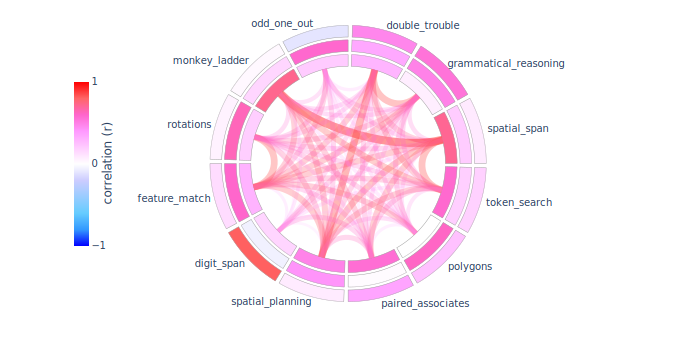

,mean,std,STM,reasoning,verbal
spatial_span,5.6633,1.0637,0.7118,0.1980,0.0838
grammatical_reasoning,17.9298,5.1899,0.0683,0.4886,0.5504
double_trouble,25.4628,15.1029,0.2896,0.3431,0.4731
odd_one_out,15.8859,2.0688,0.2028,0.5907,-0.1017
monkey_ladder,7.7026,1.1608,0.7218,0.1621,0.0271
rotations,76.3454,34.9870,0.1925,0.6345,0.0522
feature_match,114.3782,29.4716,0.2999,0.5991,0.1385
digit_span,6.6701,1.3953,0.1659,-0.0553,0.8111
spatial_planning,19.1486,9.8195,0.4876,0.4194,0.0795
paired_associates,4.6699,0.9862,0.5684,0.0152,0.3568


In [39]:
# Perform a PCA of the 12 primary CBS measures specifying 3 components and a
# varimax rotation. These choices are based on previous work with these tests:
# Hampshire et al (2012), Wild et al (2018).
pca_dmn_ctrl = FactorAnalyzer(
	method='principal',
	n_factors=3, 
	rotation='varimax').fit(Zctrl[df_])

# I know the scores turn out in this order....
domains = ['STM', 'reasoning', 'verbal']

# Build and collect dataframes that will be used for figures and table
# generation. First, the loadings.
loadings_ctrl = pd.DataFrame(
	pca_dmn_ctrl.loadings_, index=cbs.test_names(), columns=domains)

# Pairwise correlations between test scores
var_corrs = pd.DataFrame(
	pca_dmn_ctrl.corr_, 
	index=cbs.test_names(), columns=cbs.test_names())

# Eigenvalues of the components
eigen_values = pd.DataFrame(
	pca_dmn_ctrl.get_eigenvalues()[0][0:3], 
	index=domains, columns=['eigenvalues']).T

# Percentage variabnce explained by each component
pct_variance = pd.DataFrame(
	pca_dmn_ctrl.get_factor_variance()[1]*100, 
	index=domains, columns=['% variance']).T

# Generates and displays the chord plot to visualize the factors
fig_1a = chord_plot(
	loadings_ctrl.copy(), var_corrs.copy(), 
	cscale_name='Picnic', width=700, height=350, threshold=0.0)

save_and_display_figure(fig_1a, 'Figure_1A')

# Generate a table of task to composite score loadings
pca_table_ctrl = (pd
	.concat([loadings_ctrl, eigen_values, pct_variance], axis=0)
	.join(Ystats_ctrl[df_]
		.T.rename(index={r[0]: r[1] for r in zip(df_, cbs.test_names())}))
	.loc[:, ['mean', 'std']+domains]
)

pca_table_ctrl.to_csv('./outputs/tables/Table_S3.csv')

pca_table_ctrl

 ### Control Sample: Calculate Composite Cognitive Scores

In [40]:
# Calculates the 3 cognitive domain scores from the fitted PCA model
Zctrl[domains] = pca_dmn_ctrl.transform(Zctrl[df_])

# Measure of processing speed: take the 1st Principal Component across 
# timing-related features (the list of tf_), derived from ctrl group data.
pca_spd_ctrl = FactorAnalyzer(
	method='principal', 
	n_factors=1,
	rotation=None).fit(Zctrl[tf_])

# Force it to go the right away around, so higher scores are better
if pca_spd_ctrl.loadings_.mean() > 0:
	pca_spd_ctrl.loadings_ *= -1

Zctrl['processing_speed'] = pca_spd_ctrl.transform(Zctrl[tf_])

# Overall measure across CBS battery: the average of all 12 task z-scores,
# then rescale to have M = 0.0, SD = 1.0
Zctrl['overall'] = Zctrl[df_].mean(axis=1)
overall_tfm = StandardScaler(with_mean=True, with_std=True).fit(Zctrl[['overall']])
Zctrl['overall'] = overall_tfm.transform(Zctrl[['overall']])

comp_scores = cbs.DOMAIN_NAMES+['processing_speed', 'overall']
test_scores = df_

Yvar = test_scores+comp_scores

/Users/conorwild/.pyenv/versions/3.7.9/envs/cbspython-3.7/lib/python3.7/site-packages/sklearn/utils/extmath.py:376: FutureWarning:

If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.



 ## Relationship between covariate (nuisance variables) and cognitive scores.
 Here, we'll do an an exploratory analysis to see which of our common
 covariates have a relationship with cognitive scores -- in the control group.
 Simply, we will run a linear regression model for each test and composite
 score that includes all of these variables as predictors.

Regression formula: %s ~ age+sex+post_secondary+SES+exercise+nicotine+alcohol+cannabis+stimulants+depressants


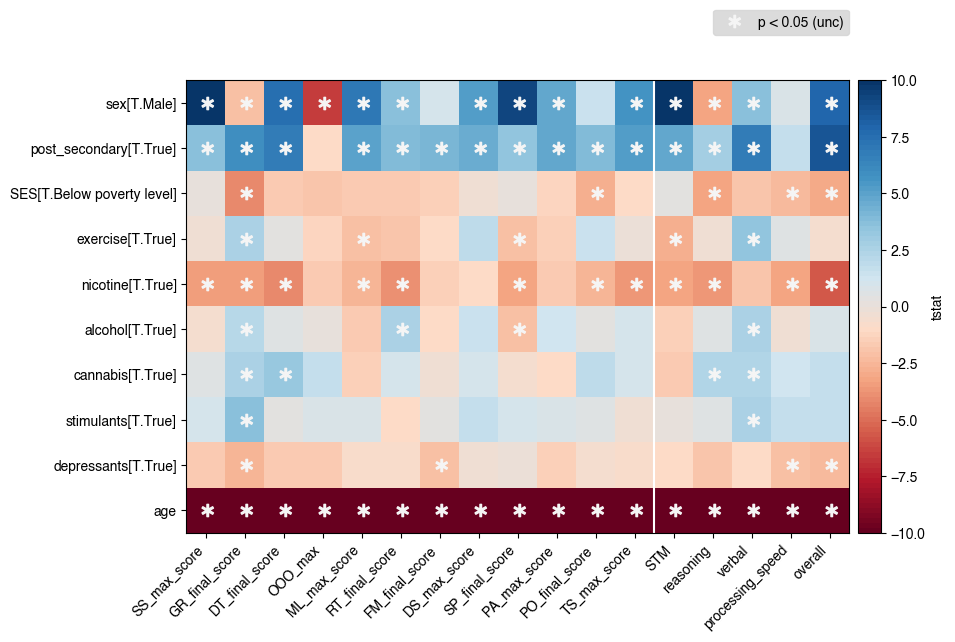

In [41]:
# Temporary duplication of the control dataset, because we modify the age 
# mean-centre the age variable for this exploratory analysis.
Zctrl_ = Zctrl.copy()
Zctrl_.age -= Zctrl_.age.mean()

covar_model = ws.build_model_expression(Xcovar)
print(f"Regression formula: {covar_model}")

# Run the linear regression models - this does one for each variable specified
# in Yvar, which is a list of all test and composite scores.
r, _ = ws.regression_analyses(covar_model, Yvar, Zctrl_)

# Generate a summary figure to show significant (p < 0.05, uncorrected) 
# relationships between covariates and cognitive scores (just exploratory)
f = wp.create_stats_figure(
	r.drop('Intercept', level='contrast', axis=0),
	'tstat', 'p', stat_range=[-10, 10], diverging=5, vertline=5)

In [42]:
# Estimate and save the betas so we can correct the COVID+ data for the same
# variables. Note that we model age using linear+quadratic terms.
from sklearn.preprocessing import PolynomialFeatures

# Transform covariates (X) variables specifying:
#	- age, as a linear and quadratic term (see age_tfm)
#	- level of education, as a binary variable with 1 = False
#	- SES growing up, as binary variable with 1 indicating  "Below poverty level"
# 	- nicotine, as binary with 1 indicating smokes > 0 cigarettes per day
# 	- exercise, as binary with 1 indicating at least once per week
# 	- cannabis, as binary with 1 indicating > 1 unit per day
# 	- stimulants, as binary with 1 indicating at least once in the last 4 wks
# 	- depressants, as binary with 1 indicating at least once in the last 4 wks

age_q_tfm = Pipeline(steps=[
	('center', StandardScaler(with_mean=True, with_std=False)),
	('poly', PolynomialFeatures(degree=2, include_bias=False)),
])

x_tfms = [
	('cont',  age_q_tfm, ['age']),
	('c_sex', OneHotEncoder(drop=['Female']), ['sex']),
	('c_edu', OneHotEncoder(drop=[False]), ['post_secondary']),
	('c_ses', OneHotEncoder(drop=['At or above poverty level']), ['SES']),
	('c_oth', OneHotEncoder(drop=[False, False, True, False, False, False]),
		['nicotine', 'alcohol', 'exercise', 'cannabis', 'stimulants', 'depressants']),
]

Xtfm = ColumnTransformer(x_tfms, sparse_threshold=0).fit(Zctrl[Xcovar])

# Alternate transformer that just mean-centres age.
age_l_tfm = StandardScaler(with_mean=True, with_std=False)
x_tfms_alt = x_tfms.copy()
x_tfms_alt[0] = ('cont',  age_l_tfm, ['age'])

# Create and fit the alternate covariate transformer
Xtfm_ = ColumnTransformer(x_tfms_alt, sparse_threshold=0).fit(Zctrl[Xcovar])

# Transform the covariate columns into a numeric matrix
# "X" denotes a design matrix, "Y" denotes the dependent variables (scores)
Xctrl = Xtfm.transform(Zctrl[Xcovar])

# Add an intercept
Xctrl = np.c_[Xctrl, np.ones(Xctrl.shape[0])]

# Solve for the the linear regression parameters. 
# We'll use these to correct the scores from both groups by subtracting the 
# expected effects (i.e., regressing them out)
Bctrl = np.dot(pinv(Xctrl), Zctrl[Yvar])

 ## COVID+ Sample
 ### Load & Process COVID Cognition Data

In [43]:
# Placeholder variables instead of typing these every time
mhvars   = ['GAD2', 'PHQ2']
subjvars = ['subjective_memory', 'baseline_functioning']
sf36vars = list(CC.questionnaire.SF36_map.keys())
severity = ['WHOc']

# Existing conditions related to COVID severity / outcomes, and / or performance
# on the CBS cognitive test battery
pre_exising_conditions = [
	'Q34_diabetes', 'Q34_obesity', 'Q34_hypertension', 'Q34_stroke', 
	'Q34_heart_attack', 'Q34_memory_problem'
]

# Load and process questionnaire data
print("\nCC Questionnaire:")
Qcc = (CC.questionnaire.data
	.rename(columns={'ses': 'SES'})
	.pipe(report_N, 'initial questionnaires', reset_count=True)
	.query('~index.duplicated(keep="first")')
	.pipe(report_N, 'remove duplicates')
	.assign(post_secondary = lambda x: x.education > 'Some university or college, no diploma')
	.assign(subjective_memory = lambda x: x.subjective_memory.cat.codes)
	.assign(pre_existing_condition = lambda x: x[pre_exising_conditions].any(axis=1))
	.assign(nicotine = lambda df: df.nicotine > 0)
	.assign(alcohol = lambda df: df.alcohol > 14)
	.assign(exercise = lambda df: df.exercise_freq >= 'Weekly')
	.assign(cannabis = lambda df: df.cannabis > 0)
	.rename(columns={'drugs_stimulants': 'stimulants', 'drugs_depressants': 'depressants'})
)

# Create an alternative WHO COVID severity variable that is: 0-1, 2, or 3+
Qcc['WHOc'] = (Qcc.WHOc
	.map({'0': '0-1', '1': '0-1', '2': '2', '3+': '3+'})
	.astype("category")
)

# Load and process the COVID+ CBS test scores, dropping any that were
# completed with an unsupported device type.
print("\nCC Scores:")
Ycc = (CC.score_data
	.pipe(set_column_names, af_)
	.reset_index('device_type')
	.groupby('user')
	.nth(0)
	.pipe(report_N, 'initial scores', reset_count=True)
	.query('~(device_type in ["BOT", "CONSOLE", "MOBILE"])')
	.pipe(report_N, 'drop unsupported devices')
)

# Combine score and questionnaire data, then chain them through a pipeline
# to remove datasets based on outliers, etc.
print("\nCC Dataset:")
Zcc = (Ycc
	.join(Qcc, how='left')
	.pipe(report_N, 'join data', reset_count=True)
	.query('(age >= 18)')
	.pipe(report_N, '>= 18 years')
	.query('(age <= 100)')
	.pipe(report_N, '<= 100 years')
	.query('sex in ["Male", "Female"]')
	.pipe(report_N, 'filter age')
	.pipe(ws.filter_df, subset=df_, sds=[6], drop=True)
	.pipe(report_N, '6 SD filter')
	.pipe(ws.filter_df, subset=df_, sds=[4], drop=True)
	.pipe(report_N, '4 SD filter')
	.dropna(subset=af_+Xcovar+mhvars+subjvars+sf36vars+severity)
	.pipe(report_N, 'drop cases with any missing values')
	.query('positive_test == "Yes"')
	.pipe(report_N, 'drop NO to positive test')
	.drop(columns=['positive_test'])
	.dropna(subset=['days_since_test'])
	.pipe(report_N, 'without a test date')
	.pipe(report_N, 'final')
	.pipe(remove_unused_categories)
)


CC Questionnaire:
N =  1745,  +1745 (initial questionnaires)
N =  1745,     +0 (remove duplicates)

CC Scores:
N =  1456,  +1456 (initial scores)
N =  1455,     -1 (drop unsupported devices)

CC Dataset:
N =  1455,  +1455 (join data)
N =  1190,   -265 (>= 18 years)
N =  1190,     +0 (<= 100 years)
N =  1186,     -4 (filter age)
N =  1182,     -4 (6 SD filter)
N =  1164,    -18 (4 SD filter)
N =   942,   -222 (drop cases with any missing values)
N =   484,   -458 (drop NO to positive test)
N =   478,     -6 (without a test date)
N =   478,     +0 (final)


 ## COVID+ Sample
 ### Compare factor structure of cognitives scores to CTRL data/

/Users/conorwild/.pyenv/versions/3.7.9/envs/cbspython-3.7/lib/python3.7/site-packages/sklearn/utils/extmath.py:376: FutureWarning:

If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.



COVID+ Factor Structure


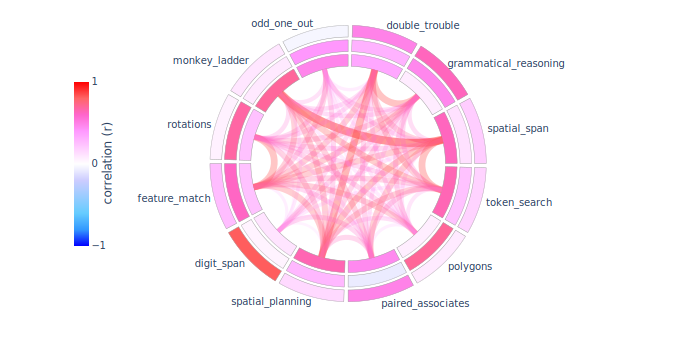

CTRL Factor Structure


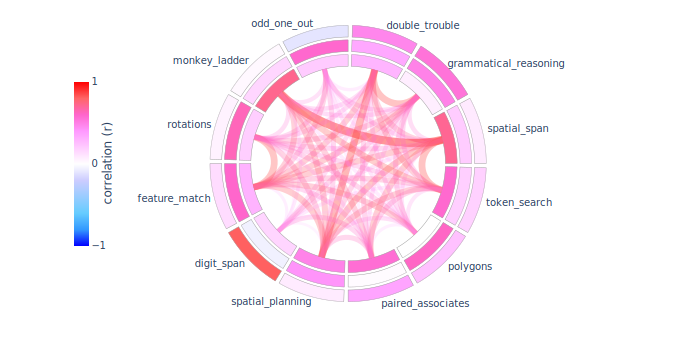

,mean,std,STM,reasoning,verbal
spatial_span,5.6192,0.9870,0.6281,0.1191,0.1979
grammatical_reasoning,17.0418,5.4340,0.0756,0.4710,0.6285
double_trouble,19.2887,15.4932,0.3455,0.3002,0.4893
odd_one_out,15.7762,1.9943,0.4797,0.4067,-0.0354
monkey_ladder,7.4916,1.1633,0.6953,0.0857,0.0966
rotations,73.3138,35.4411,0.2427,0.6785,0.0560
feature_match,110.1799,32.0041,0.2391,0.6148,0.2584
digit_span,6.6506,1.2661,0.1045,0.0480,0.8184
spatial_planning,18.8682,8.3071,0.6485,0.2792,0.1490
paired_associates,4.5021,0.9265,0.4619,-0.0766,0.4912


/Users/conorwild/.pyenv/versions/3.7.9/envs/cbspython-3.7/lib/python3.7/site-packages/sklearn/utils/extmath.py:376: FutureWarning:

If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.



,STM,reasoning,verbal,processing_speed
procrustes,,,,
False,0.9701,0.9764,0.9744,0.9975
True,0.9795,0.9870,0.9827,0.9987


In [44]:
# Copy of the original dataframe, because some figures, etc. have different
# codings for variables.
Zcc_ = Zcc.copy()

# Original score means and SDs, for use in a summary table.
Ystats_cc = Zcc_[af_].agg(['mean', 'std'])

# Z-score the test score features w/r/t to this sample (COVID+)
Zcc_[af_] = Pipeline(
	steps=[('center', StandardScaler(with_mean=True, with_std=True)),
		   ('yeo', PowerTransformer(method='yeo-johnson'))]
).fit_transform(Zcc_[af_].values)

# Perform rotated PCA analysis, specifying 3 components like in the CTRL group.
pca_dmn_cc = FactorAnalyzer(
	method='principal',
	n_factors=3, 
	rotation='varimax').fit(Zcc_[df_])

# Build and collect dataframes that will be used for figures and tables...

# Component (factor) loadings
loadings_cc = pd.DataFrame(
	pca_dmn_cc.loadings_, 
	index=cbs.test_names(), columns=domains)

# Pair-wise correlations between variables
var_corrs_cc = pd.DataFrame(
	pca_dmn_cc.corr_, 
	index=cbs.test_names(), columns=cbs.test_names())

# Eigenvalues of the components
eigen_values = pd.DataFrame(
	pca_dmn_cc.get_eigenvalues()[0][0:3], 
	index=domains, columns=['eigenvalues']).T

# % Variance explained by each component
pct_variance = pd.DataFrame(
	pca_dmn_cc.get_factor_variance()[1]*100, 
	index=domains, columns=['% variance']).T

# Create a table of loadings, test means/SDs, eigenvalues, % variance, etc.
pca_table_cc = (pd
	.concat([loadings_cc, eigen_values, pct_variance], axis=0)
	.join(Ystats_cc[df_]
		.T.rename(index={r[0]: r[1] for r in zip(df_, cbs.test_names())}))
	.loc[:, ['mean', 'std']+domains]
)

# Generates and displays the chord plot to visualize the factors
fig_1x = chord_plot(
	loadings_cc.copy(), var_corrs.copy(), 
	cscale_name='Picnic', width=700, height=350, threshold=0.0)

print("COVID+ Factor Structure")
save_and_display_figure(fig_1x, 'Figure_S5b')

print("CTRL Factor Structure")
save_and_display_figure(fig_1a, 'Figure_1A')

pca_table_cc.to_csv('./outputs/tables/Table_S4.csv')
display(pca_table_cc)

# Replicate the "processing speed" score?
pca_spd_cc = FactorAnalyzer(
	method='principal', 
	n_factors=1,
	rotation=None).fit(Zcc[tf_])

# Force it to go the right away around, so higher scores are better
if pca_spd_cc.loadings_.mean() > 0:
	pca_spd_cc.loadings_ *= -1

# Next, compare the similarity of the factor (domain) structures produced from
# each group (COVID+ and CTRL).
trg = pca_dmn_ctrl.loadings_
src = pca_dmn_cc.loadings_

# Calculates the congruency coeffient for each factor twice, 1st without doing
# a procustes transformation, 2nd time with the transformation.
domain_coefs = [tuckersCC(trg, src, do_procrustes = x) for x in [False, True]]

trg = pca_spd_ctrl.loadings_
src = pca_spd_cc.loadings_
speed_coefs = [tuckersCC(trg, src, do_procrustes = x) for x in [False, True]]

factor_similarities = (pd
	.DataFrame(
		np.vstack(domain_coefs),
		index = [False, True], columns = domains)
	.rename_axis('procrustes', axis = 0)
	.assign(processing_speed = np.squeeze(speed_coefs))
)

factor_similarities.to_csv('./outputs/tables/Table_S5.csv')
display(factor_similarities)

In [45]:
# Standardizes all score features using the transformer that was fitted on the 
# control sample data (i.e., using the control sample means and SDs, etc.)
# Now, cognitive scores will be relative to the CTRL group.
Zcc[af_] = Ytfm.transform(Zcc[af_])

# Calculate the composite scores
Zcc[domains] = pca_dmn_ctrl.transform(Zcc[df_])
Zcc['processing_speed'] = pca_spd_ctrl.transform(Zcc[tf_])
Zcc['overall'] = overall_tfm.transform(Zcc[df_].mean(axis=1).values.reshape(-1,1))

/Users/conorwild/.pyenv/versions/3.7.9/envs/cbspython-3.7/lib/python3.7/site-packages/sklearn/base.py:439: UserWarning:

X has feature names, but StandardScaler was fitted without feature names

/Users/conorwild/.pyenv/versions/3.7.9/envs/cbspython-3.7/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



Regression Model: %s ~ age+sex+post_secondary+SES+exercise+nicotine+alcohol+cannabis+stimulants+depressants


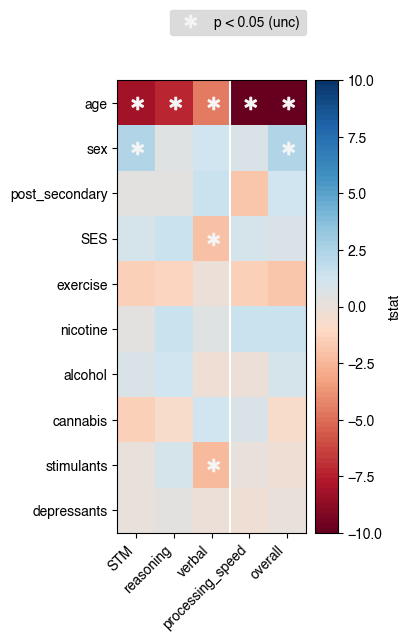

In [46]:
# Exploratory analysis to show significant (uncorrected) relationships
# between (uncorrected) cognitive scores in the COVID+ group and all the
# various covariates.

Zcc_ = Zcc.copy()
Zcc_[Xcovar] = Xtfm_.transform(Zcc_[Xcovar])
covar_model = ws.build_model_expression(Xcovar)
print(f"Regression Model: {covar_model}")

r, _ = ws.regression_analyses(covar_model, comp_scores, Zcc_)

# Generate a summary figure to show significant (p < 0.05, uncorrected) 
# relationships between covariates and cognitive scores (just exploratory)
f = wp.create_stats_figure(
	r.drop('Intercept', level='contrast', axis=0), 'tstat', 'p_adj', 
	correction=None, stat_range=[-10, 10], diverging=True, vertline=2)

Zcc = Zcc.rename(columns={'WHOi': 'WHO_COVID_severity'})

In [47]:
# Report the # of responses for COVID-19 related questions and pre-existing 
# health conditions.
covid_vars = ['symptoms', 'hospital_stay', 'daily_routine', 'supplemental_O2_hospital', 'ICU_stay', 'ventilator']
q_counts = Zcc[covid_vars].copy()
q_counts.loc[:, 'symptoms'] = q_counts['symptoms'].map({True: "Yes", False: "No"})
q_counts = [q_counts[c].value_counts() for c in covid_vars]
q_counts = pd.concat(q_counts, axis=1).T
display(q_counts)

(Zcc[covid_vars+pre_exising_conditions]
	.to_csv('./outputs/tables/table_data_T1.csv')
)

print(f"\nNumber of participants with a pre-existing condition: {Zcc.pre_existing_condition.sum()}")
display(Zcc[pre_exising_conditions].sum(axis=0))

,Don't Know,No,Yes
symptoms,NaN,28.0000,450.0000
hospital_stay,NaN,412.0000,66.0000
daily_routine,NaN,283.0000,129.0000
supplemental_O2_hospital,1.0000,31.0000,34.0000
ICU_stay,NaN,49.0000,17.0000
ventilator,NaN,6.0000,11.0000



Number of participants with a pre-existing condition: 112


Q34_diabetes          23
Q34_obesity           80
Q34_hypertension      47
Q34_stroke             4
Q34_heart_attack       1
Q34_memory_problem     2
dtype: object

In [48]:
# Generate tables of distributions and frequencies for variables that
# describe the two groups.

# These need to be coded in the control dataset
lang_vars = {l: f"speak_{l.lower()}" for l in ['English', 'French', 'Spanish']}
for l, v in lang_vars.items():
	Qctrl[v] = Qctrl['languages_spoken'].map(
		lambda x: l in x if isinstance(x, str) else False)
lang_vars = list(lang_vars.values())

# Join the two datasets together so we can do .groupby etc.
covar_data = pd.concat(
	[Zctrl[Xcovar].join(Qctrl[['country']+lang_vars]), 
	 Zcc[Xcovar+lang_vars+['country']]], axis=0, 
	names=['dataset'], keys=['Control', 'COVID+'])

(covar_data
	.reset_index('dataset')
	.to_csv('./outputs/tables/table_data_T2.csv', index=False)
)

grp_counts = (covar_data
	.groupby('dataset')
	.agg('count')
	.iloc[:, 0]
)

catg_vars = pd.concat(
	{ v: (covar_data
			.groupby('dataset')[v]
			.value_counts()
			.to_frame()
			.rename(columns={v: 'count'})
			.assign(pct = lambda x: x['count'] / grp_counts * 100)
			.unstack('dataset')
			.swaplevel(axis=1).sort_index(axis=1)
		) for v in Xcovar[1:] + lang_vars
	}
)
save_and_display_table(catg_vars, 'Table_2a')

cont_vars = pd.concat(
	{ v: (covar_data
			.groupby('dataset')
			.agg(['mean', 'std'])[[v]]
			.T
			.unstack(1)
		) for v in ['age']
	}
)
save_and_display_table(cont_vars, 'Table_2b')

top5_countries = (pd.concat(
		{ dataset:
			(covar_data
				.xs(dataset)
				.loc[:, 'country']
				.value_counts(ascending=False)
				.iloc[0:5]
			) for dataset in ['COVID+', 'Control']
		}, names=['dataset'])
	.to_frame()
	.rename(columns={'country': 'count'})
	.assign(pct = lambda x: x['count'] / grp_counts * 100)
)
save_and_display_table(top5_countries, 'Table_2c')

 ### COVID+ Sample: GAD-2 & PHQ-2 Summary

In [49]:
n_GAD_flag = (Zcc.GAD2>=3).sum()
print(f"GAD2 >= 3, N = {n_GAD_flag} ({n_GAD_flag/Zcc.shape[0]*100:.01f}%)")

n_PHQ_flag = (Zcc.PHQ2>=3).sum()
print(f"PHQ2 >= 3, N = {n_PHQ_flag} ({n_PHQ_flag/Zcc.shape[0]*100:.01f}%)")

GAD2 >= 3, N = 159 (33.3%)
PHQ2 >= 3, N = 151 (31.6%)


 ## COVID+ Sample: Health Measures

chi2 = 2167.52, p = 0.0000
KMO = 0.87


/Users/conorwild/.pyenv/versions/3.7.9/envs/cbspython-3.7/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



,mean,std,F1,F2
SF36_physical_functioning,69.4767,29.1303,0.8414,0.0073
SF36_role_limitations_physical,37.0816,43.0336,0.7820,0.1123
SF36_role_limitations_emotional,56.3459,43.2269,0.2453,0.6117
SF36_energy_fatigue,33.9052,23.9809,0.7773,0.3039
SF36_pain,66.7364,26.0717,0.6853,0.1503
GAD2,2.1130,1.9490,0.2047,0.7549
PHQ2,2.0042,1.8599,0.3694,0.7306
subj_memory,2.2803,1.0078,0.5815,0.2302
subj_baseline,0.3222,0.4678,0.6253,0.2091
WHO_COVID_severity,0.7301,0.4444,-0.4659,-0.0208


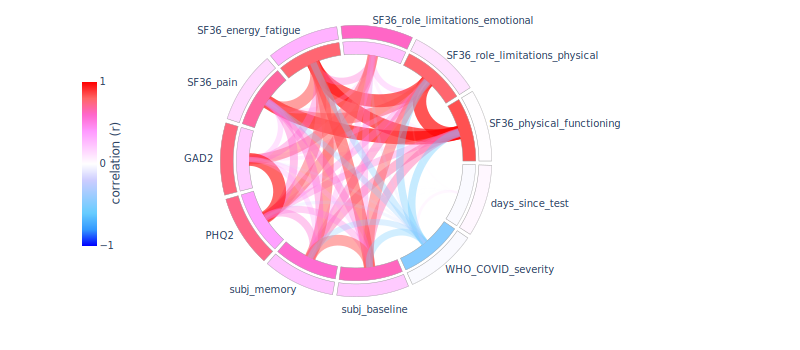

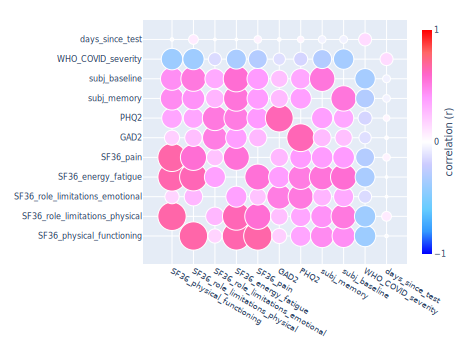

In [50]:
# The questionnaire variables we are incorporating into the factor analysis:
fvars = mhvars + subjvars + sf36vars + ['WHO_COVID_severity', 'days_since_test']
fdata = Zcc[fvars].copy().dropna()	# copy it so we don't mess up the original df

var_rename = {
	'baseline_functioning_Yes': 'subj_baseline',
	'baseline_functioning': 'subj_baseline',
	'subjective_memory': 'subj_memory',
}

var_order = sf36vars + mhvars + [
	'subj_memory',
	'subj_baseline',
	'WHO_COVID_severity',
	'days_since_test'
]

fdata.WHO_COVID_severity = fdata.WHO_COVID_severity >= 2
fdata_tfm = ColumnTransformer([
	('z', StandardScaler(), sf36vars+['days_since_test']),
	('r', MinMaxScaler(feature_range=(-1,1)), mhvars+['subjective_memory', 'WHO_COVID_severity']),
	('c', OneHotEncoder(drop='first'), ['baseline_functioning']),
]).fit(fdata)

fdata_desc = (fdata
	.assign(baseline_functioning=fdata['baseline_functioning'].cat.codes)
	.agg(['mean', 'std']).T
	.rename(var_rename)
	.loc[var_order, :]
)

fdata0 = (pd
	.DataFrame(
		fdata_tfm.transform(fdata),
		index=fdata.index,
		columns=ws.get_ct_feature_names(fdata_tfm))
	.rename(columns=var_rename)
	.loc[:, var_order]
)

# Reverse GAD-2 and PHQ-2 so they go in the same direction as other measures
# for these plots, and calculations of factor scores.
fdata0[mhvars] *= -1

# Fit the factor model, no rotation at first.
fa1 = FactorAnalyzer(rotation=None).fit(fdata0)

# Determine number of factors, given eigenvalues > 1.0
nf = (fa1.get_eigenvalues()[1]>1).sum()
fnames = [f"F{i+1}" for i in range(nf)] # name them F1 ... FN for now

# Bartlett; p-value should be 0 (statistically sig.)
chi_square_value,p_value=calculate_bartlett_sphericity(fdata0)
print(f"chi2 = {chi_square_value:.02f}, p = {p_value:.04f}")

# KMO; Value should be > 0.6
kmo_all,kmo_model=calculate_kmo(fdata0)
print(f"KMO = {kmo_model:.02f}")

# Now do the factor analysis retaining only the the number of factors,
# and do a rotation (Varimax)
rotation = "varimax"
fa = FactorAnalyzer(nf, rotation=rotation)
fa = fa.fit(fdata0)

# Calculate Factor scores using the fitted factor model
# - one new column per factor score (named F1 ... FN)
# - rescale to have SD = 1.0
Zcc[fnames] = np.nan
Zcc.loc[fdata0.index, fnames] = (
	StandardScaler()
		.fit_transform(
			fa.transform(fdata0)
		)
)

# Loadings table
loadings = pd.DataFrame(
	fa.loadings_, index=fdata0.columns, columns=fnames)

# Eigenvalues of each factor (for table)
eigen_values = pd.DataFrame(
	fa.get_eigenvalues()[0][0:nf], index=fnames, columns=['eigenvalues']).T

# Percentage variance explained by each factor (for table)
pct_variance = pd.DataFrame(
	fa.get_factor_variance()[1]*100, index=fnames, columns=['% variance']).T

# Combine to generate the 
table = (pd
	.concat([loadings, eigen_values, pct_variance], axis=0)
	.join(fdata_desc)
	.loc[:, ['mean', 'std']+fnames]
)

table.to_csv(f"./outputs/tables/Table_S2.csv")
display(table)

# Visualize the factor structure with a chord plot
f = chord_plot(
		loadings, fdata0[var_order].corr(), 
		width=800, height=350, cscale_name='Picnic', threshold=0.0)

save_and_display_figure(f, 'Figure_1B')

# Correlations between health measures (same as shown in the above chord plot)
f = wp.correlogram(fdata0, subset=var_order, mask_diag=True)
save_and_display_figure(f, 'Figure_S2')

In [51]:
# Defines columns that will be used in various stats tables
comp_columns = ['dR2', 'f2', 'BF10']					# model comparison stats
regr_columns = ['B', 'tstat', 'df', 'p_adj', 'CI']		# regression parameters
ttest_columns = ['diff', 'tstat', 'df', 'p_adj', 'CI', 'BF10'] # t-test stats
column_order = regr_columns + comp_columns

 ## Relationships Between Factor Scores and Covariates

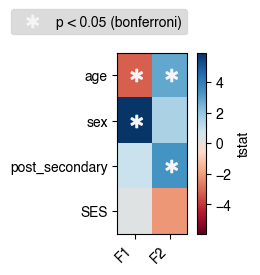

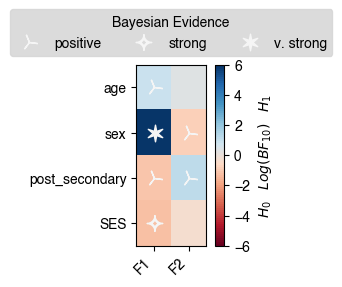

In [52]:
Zcc_ = Zcc.copy()
Zcc_[Xcovar] = Xtfm_.transform(Zcc[Xcovar])

# Build and estimate regression models for each health factor score
# (fnames) using the expression: '~ age + sex + post_secondary + SES'.
r0_regressions, _ = ws.regression_analyses(
	'%s ~ age + sex + post_secondary + SES', fnames, Zcc_, n_comparisons=8)

# Then, we perform model comparisons where the null or reduced model (h0) does
# not contain the variable of interest, whereas the alternative model (h1) DOES.
# This function returns Bayes factors, effect sizes, likelihood ratios, etc.
r0_comparisons = ws.compare_models([
	{ 'name': 'age',
		'h0': '%s ~ sex + post_secondary + SES', 
		'h1': '%s ~ age + sex + post_secondary + SES' }, 
	{ 'name': 'sex',
		'h0': '%s ~ age + post_secondary + SES', 
		'h1': '%s ~ age + sex + post_secondary + SES' },
	{ 'name': 'post_secondary',
		'h0': '%s ~ age + sex + SES', 
		'h1': '%s ~ age + sex + post_secondary + SES' },
	{ 'name': 'SES',
		'h0': '%s ~ age + sex + post_secondary', 
		'h1': '%s ~ age + sex + post_secondary + SES' }],

	Zcc_, fnames, smf.ols, n_comparisons=8)

# Combine and reorganize the results tables
r0_table = (r0_regressions
	.drop('Intercept', level='contrast')
	.join(r0_comparisons.loc[:, comp_columns])
	.rename(columns={'value': 'B'})
	.loc[:, column_order]
)

# Display stats figure (here)
f1_ts = wp.create_stats_figure(
	r0_table, 'tstat', 'p_adj', diverging=True, vertline=None, 
	correction='bonferroni')

f1_bf = wp.create_bayes_factors_figure(r0_table, cell_scale=0.6)

# Save / show the stats table
save_and_display_table(r0_table, 'Table_S6')

 ### Plots of Factors Scores vs. Covariates

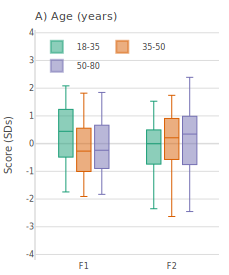

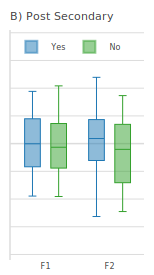

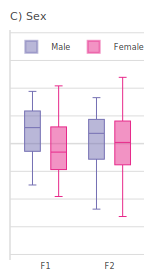

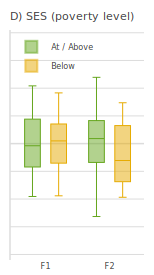

In [53]:
from plotly.colors import colorbrewer as cb

Zcc_ = Zcc.copy()
age_edges = np.array([18, 30, 60, 100])
age_bins = ['18-30', '30-60', '60+']
Zcc_['age_bin'] = pd.cut(Zcc_['age'], age_edges, labels=age_bins)
Zcc_['post_secondary'] = Zcc_['post_secondary'].map({True: 'Yes', False: 'No'})

_, age_bins = pd.qcut(Zcc_['age'], 3, labels=False, retbins=True, precision=0)
age_bins = [f"{int(x)}-{int(age_bins[i+1])}" for i, x in enumerate(age_bins[:-1])]
Zcc_['age_bin'] = pd.qcut(Zcc_['age'], 3, labels=age_bins)

# CELL Reports Medicine:
# For 2-column formats (such as research articles and reviews), the sizes are 
# 85 mm (1 column), 114 mm (1.5 columns), and 174 mm (full width of the page).
# For color figures, the resolution should be 300 dpi at the desired print size
# For black and white figures, the resolution should be 500 dpi at the desired print size
# For line-art figures, the resolution should be 1,000 dpi at the desired print size 
import importlib
importlib.reload(wp)

w1_mm = 58 #mm
w2_mm = 39 #mm

wp.rc_title.update(text = 'A) Age (years)')
wp.rc_layout.update(
	boxgroupgap = 0.2, 
	width = wp.mm_to_pts(w1_mm, dpi=1000),
)

# F1/F2 as a function of Age
age_plot = wp.raincloud_plot(
	Zcc_, ['F1', 'F2'], 'age_bin', grp_order=age_bins,
	do_vio = False, do_pts = False, sym_constant=True, sym_offset=1,
	box_args = {'boxpoints': 'outliers'}
)
save_and_display_figure(age_plot, 'Figure_2a')

wp.rc_layout.update(
	boxgroupgap = 0.4, 
	width = wp.mm_to_pts(w2_mm, dpi=1000),
)
wp.rc_yaxis.update(showticklabels = False, title = None)
wp.rc_layout['margin'].update(l=10)
wp.rc_title.update(text = 'B) Post Secondary')

# F1/F2 as a function of post-secondary education
edu_plot = wp.raincloud_plot(
	Zcc_, ['F1', 'F2'], 'post_secondary',
	grp_colours = [cb.Paired[c] for c in [1,3]],
	do_vio = False, do_pts = False, sym_constant=True, sym_offset=1,
	box_args = {'boxpoints': 'outliers'}
)
save_and_display_figure(edu_plot, 'Figure_2b')

# F1/F2 as a function of sex
wp.rc_title.update(text = 'C) Sex')
sex_plot = wp.raincloud_plot(
	Zcc_, ['F1', 'F2'], 'sex', colour_offset = 2,
	do_vio = False, do_pts = False, sym_constant=True, sym_offset=1,
	box_args = {'boxpoints': 'outliers'}
)
save_and_display_figure(sex_plot, 'Figure_2c')

Zcc2 = Zcc_.copy()
Zcc_['SES'] = Zcc_['SES'].cat.rename_categories(
	{'At or above poverty level': 'At / Above', 'Below poverty level': 'Below'}
)

# F1/F2 as a function of SES
wp.rc_title.update(text = 'D) SES (poverty level)')
ses_plot = wp.raincloud_plot(
	Zcc_, ['F1', 'F2'], 'SES', colour_offset = 4,
	do_vio = False, do_pts = False, sym_constant=True, sym_offset=1,
	box_args = {'boxpoints': 'outliers'}
)
save_and_display_figure(ses_plot, 'Figure_2d')

 ## COVID+ vs. Control - Comparisons of Cognitive Performance

In [54]:
# Before comparing the groups, we will correct for all the estimated
# effects of those confounding variables.

# Adjust the CTRL group for the covariates...
Yctrl_hat = Xctrl.dot(Bctrl)
Zctrl[Yvar] -= Yctrl_hat

# Adjust the COVID+ group for the covariates...
Xcc = Xtfm.transform(Zcc[Xcovar])
Xcc = np.c_[Xcc, np.ones(Xcc.shape[0])]
Ycc_hat = Xcc.dot(Bctrl)
Zcc[Yvar] -= Ycc_hat

# Concatenate the COVID+ and Control datasets for subsequent comparisons 
# between groups
Zall = pd.concat([Zcc, Zctrl], axis=0, keys=['CC', 'CTRL'], names=['study'])

In [55]:
# First, perform the t-tests comparing each composite score between groups,
# where group is specified by the 'study' column. Manually specifying 15
# comparisons because there are 5 DVs, but we are including the tests of 
# regression parameters from following analyses.
r1_ttests = (ws
	.two_sample_ttests('study', comp_scores, Zall, n_comparisons=15)
	.droplevel('contrast')
)

save_and_display_table(r1_ttests[ttest_columns], 'Table_3')

,diff,tstat,df,p_adj,CI,BF10
score,,,,,,
STM,0.056226,1.38,543.80,1.000,"(-0.064, 0.177)",0.14
reasoning,-0.197252,-4.26,530.10,< 0.001,"(-0.334, -0.061)",424.92
verbal,-0.184174,-4.07,540.49,< 0.001,"(-0.318, -0.051)",194.48
processing_speed,-0.293263,-6.67,527.97,< 0.001,"(-0.423, -0.164)",> 1000
overall,-0.162531,-3.96,532.52,0.001,"(-0.284, -0.041)",124.22


 ## COVID+ vs. Control - Plots of Mean Scores
 - Divide the COVID+ sample into tercile bins (each has 33%) on each factor
 - Remember, Y=0.0 is the control sample mean

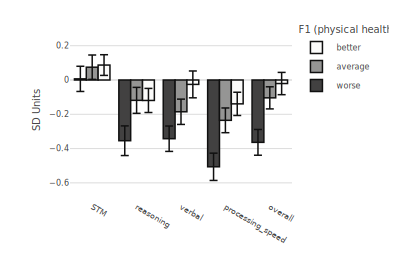

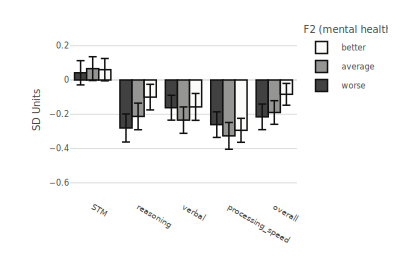

In [56]:
f1_edges = np.array([-np.Inf, *Zcc['F1'].quantile(q=np.array([1,2])/3).values, np.Inf])
f2_edges = np.array([-np.Inf, *Zcc['F2'].quantile(q=np.array([1,2])/3).values, np.Inf])
labels = ["worse", "average", "better"]
Zcc['F1_bin'] = pd.cut(Zcc['F1'], bins=f1_edges, labels=labels)
Zcc['F2_bin'] = pd.cut(Zcc['F2'], bins=f2_edges, labels=labels)

bar_args = {
	'range_y': [-0.7, 0.35],
	'labels': {'mean': 'SD Units'},
}

layout_args = {
	'xaxis': {
		'title': None, 
	},
	'yaxis': {
		'tickmode': 'array',
		'tickvals': np.arange(-0.6, 0.7, 0.2).round(1),
	},
	'width': 400, 'height': 275,
	'margin': {'l': 70, 'b': 75, 't': 20, 'r': 20},
	'legend_traceorder': 'reversed',
	'legend': {
		'title': "F1 (physical health)", 'orientation': 'v',
		'yanchor': 'top', 'xanchor': 'left', 'x': 1.02, 'y': 1.0,
	},
}
import plotly.graph_objects as go
bwmap = wc.create_mpl_cmap(plotly.colors.sequential.gray, alpha=1.0)
grayscale_map = wc.to_RGB_255(bwmap(np.linspace(0.3, 1.0, 3)))

f3a, _ = wp.means_plot(
	Zcc, comp_scores, 'score', group='F1_bin',
	group_color_sequence=grayscale_map,
	bar_args=bar_args, layout_args=layout_args 
)
save_and_display_figure(f3a, 'OLD_Figure_3A')

layout_args['legend']['title'] = 'F2 (mental health)'
f3b, _ = wp.means_plot(
	Zcc, comp_scores, 'score', group='F2_bin',
	group_color_sequence=grayscale_map,
	bar_args=bar_args, layout_args=layout_args 
)
save_and_display_figure(f3b, 'OLD_Figure_3B')

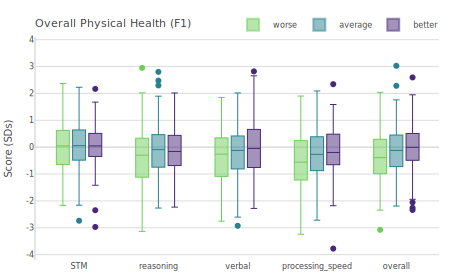

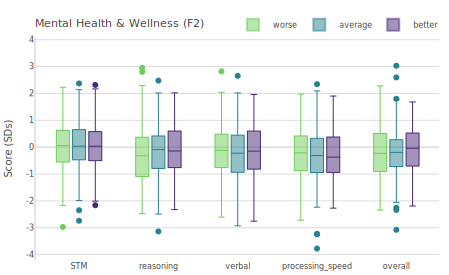

In [57]:
# Box plots for cognitive scores by health factor

# Resets the plot layout options to my defaults...
importlib.reload(wp)

fwidth_mm = 114 # mm
viridis_map = [plotly.colors.sequential.Viridis_r[i] for i in [2,5,8]]

wp.rc_layout.update(
	width = wp.mm_to_pts(fwidth_mm, dpi=1000),
)

wp.rc_legend.update(
	xanchor='right', yanchor='bottom', x=1, y=0.99,
)

wp.rc_title.update(text = 'Overall Physical Health (F1)')
f1_bin_plot = wp.raincloud_plot(
	Zcc, comp_scores, 'F1_bin', grp_order=labels,
	grp_colours = viridis_map,
	do_vio = False, do_pts = False, sym_constant = True, sym_offset = 1,
	box_args = {'boxpoints': 'outliers'}
)
save_and_display_figure(f1_bin_plot, 'Figure_3a')


wp.rc_title.update(text = 'Mental Health & Wellness (F2)')
f2_bin_plot = wp.raincloud_plot(
	Zcc, comp_scores, 'F2_bin', grp_order=labels,
	grp_colours = viridis_map,
	do_vio = False, do_pts = False, sym_constant = True, sym_offset = 1,
	box_args = {'boxpoints': 'outliers'}
)
save_and_display_figure(f2_bin_plot, 'Figure_3b')

 ## COVID+ Binned Groups vs. Controls

In [58]:
# Compare groups in F1 bins to controls
r3a_ttests = {}
for grp, grp_data in Zcc.groupby('F1_bin'):
	Zall = pd.concat([grp_data, Zctrl], keys=['CC', 'SS'], names=['study'])
	r3a_ttests[grp] = (ws
		.two_sample_ttests('study', comp_scores, Zall, n_comparisons=15)
		.droplevel('contrast')
	)
r3a_ttests = pd.concat(r3a_ttests.values(), axis=0, keys=r3a_ttests.keys(), names=['F1_bin'])

save_and_display_table(r3a_ttests[ttest_columns], 'Table_S7')

# Compare groups in F2 bins to controls
r3b_ttests = {}
for grp, grp_data in Zcc.groupby('F2_bin'):
	Zall = pd.concat([grp_data, Zctrl], keys=['CC', 'SS'], names=['study'])
	r3b_ttests[grp] = (ws
		.two_sample_ttests('study', comp_scores, Zall, n_comparisons=15)
		.droplevel('contrast')
	)
r3b_ttests = pd.concat(r3b_ttests.values(), axis=0, keys=r3b_ttests.keys(), names=['F2_bin'])

save_and_display_table(r3b_ttests[ttest_columns], 'Table_S7b')

 ## COVID+ Sample - Predict Cognitive Performance From Health Factors

Model expression: %s ~ F1+F2


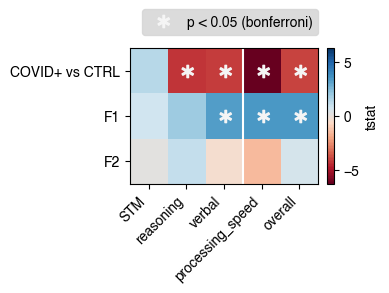

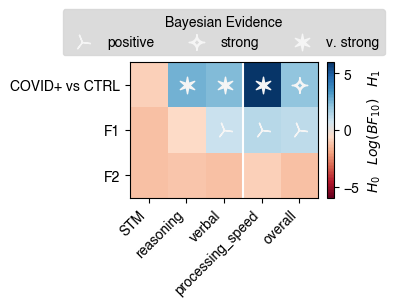

In [59]:
# Build and estimate regression models for each composite cognitive score

full_model = ws.build_model_expression(fnames)
print(f"Model expression: {full_model}")

# This function constructs and estimates a linear regression model for each of
# the DVs (the 5 composite scores) using the "full model" formula, which
# in this case is just ~ F1 + F2.
r1_regressions, r1_models = ws.regression_analyses(
		full_model, comp_scores, Zcc, n_comparisons=15)

# Then, we perform model comparisons where the null or reduced model (h0) does
# not contain the variable of interest, whereas the alternative model (h1) DOES.
# This function returns Bayes factors, effect sizes, likelihood ratios, etc.
r1_comparisons = ws.compare_models([
	{'name': 'F1',
		'h0': ws.build_model_expression("F2"), # Null hypothesis doesn't include F1
		'h1': full_model}, 
	{'name': 'F2',
		'h0': ws.build_model_expression("F1"), # Null hypothesis doesn't include F2
		'h1': full_model}
	], Zcc, comp_scores, smf.ols, n_comparisons=15)

# Extract and combine the various statistics from the above regression
# analyses and build the table of results. We are only keeping rows for the 
# regressors of interest (not going to keep parameters etc. for nuisance vars)
res1_ = (r1_regressions
	.join(r1_comparisons.loc[:, comp_columns])
	.rename(columns={'value': 'B'})
	.loc[r1_comparisons.index, column_order]
)

save_and_display_table(res1_, 'Table_4')

# Generate figures to summarize these results...
plot_cols = ['tstat', 'p_adj', 'BF10']
renamer = {'group': 'COVID+ vs CTRL'}
res1_fig = (
	pd.concat(
		[pd.concat([r1_ttests[plot_cols]], keys=['group'], names=['contrast']).swaplevel(),
		 res1_[plot_cols]], axis=0
	)
	.loc[idx[comp_scores, :], :]
	.rename(renamer)
)

# Matrix of t-tstatistics
f1_ts = wp.create_stats_figure(
	res1_fig, 'tstat', 'p_adj', diverging=True, vertline=2,
	correction='bonferroni', stat_range=[-6.3, 6.3])

# Matrix of BFs
f1_bf = wp.create_bayes_factors_figure(res1_fig, suppress_h0=True, vertline=2)

f1_ts.savefig('./outputs/images/Figure_S5A.svg')
f1_bf.savefig('./outputs/images/Figure_S5B.svg')

 ### QQ-Plots
 - Check that residuals from the regression models are normally distributed!

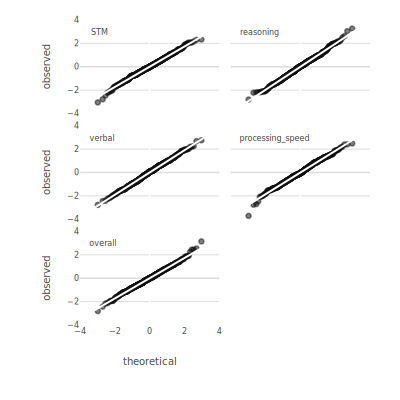

In [60]:
qq_nms, qq_res = np.empty([3, 2], dtype='object'), np.empty([3,2], dtype='object')
for im, m in enumerate(r1_models):
	ir, ic = np.unravel_index(im, [3,2])
	qq_res[ir, ic] = probplot(m.resid, dist="norm")
	qq_nms[ir, ic] = m.model.endog_names

qq_f = wp.qq_plots(qq_res, qq_nms,
	layout_args = {'width': 400, 'height': 400}
)

save_and_display_figure(qq_f, 'Figure_S4')

 ## Supplementary Analysis

 Let's include a bunch of covariates in the regression models to see if they
 explain the relationship(s) between F1 and cognitive scores. We'll include all
 the coviariates of no interest (Xcovar) that are common to both groups
 (age, sex, level of education, SES, exercise, smoking, alcohol, other
 stimulants, and other depressants). These have already been regressed out
 using parameters estimated from the control group, but there might be
 residual effects.

 Also, we'll include a binary predictor that indicates the presence of a pre-
 exisiting medical condition.

In [61]:
# Include covariates in the model expression(s)

full_model_w_covar = ws.build_model_expression(fnames, Xcovar, 'pre_existing_condition')
print(f"Full model: {full_model_w_covar}")
r1b_regressions, _ = ws.regression_analyses(
		full_model_w_covar, comp_scores, Zcc, n_comparisons=15)

r1b_comparisons = ws.compare_models([
	{'name': 'F1',
		'h0': ws.build_model_expression('F2', Xcovar, 'pre_existing_condition'),
		'h1': full_model_w_covar}, 
	{'name': 'F2',
		'h0': ws.build_model_expression('F1', Xcovar, 'pre_existing_condition'),
		'h1': full_model_w_covar}
	], Zcc, comp_scores, smf.ols, n_comparisons=15)

res1b_ = (r1b_regressions
	.join(r1b_comparisons.loc[:, comp_columns])
	.rename(columns={'value': 'B'})
	.loc[r1b_comparisons.index, column_order]
)

save_and_display_table(res1b_, 'Table_S8')

Full model: %s ~ F1+F2+age+sex+post_secondary+SES+exercise+nicotine+alcohol+cannabis+stimulants+depressants+pre_existing_condition


 ## COVID+ Subgroup Analyses: Hospitalised vs Non-Hospitalised Cases

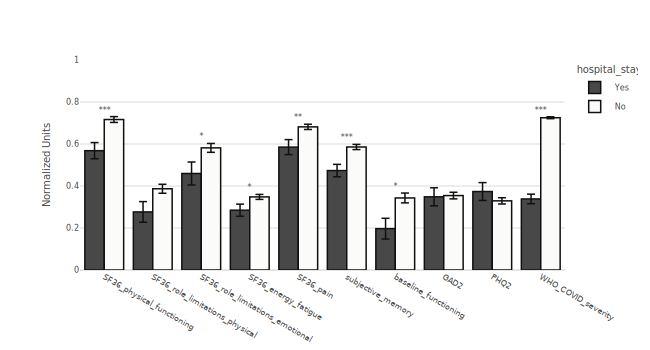

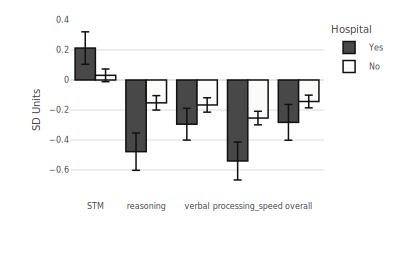

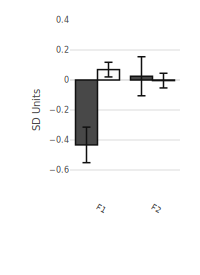

In [62]:
# Compare means of measures that make up F1
hms = sf36vars+subjvars+mhvars+['WHO_COVID_severity']
Zcc['hospital_stay'] = Zcc['hospital_stay'].cat.remove_unused_categories()
Xhm = Zcc.loc[:, hms+['hospital_stay']]
Xhm['WHO_COVID_severity'] = Xhm['WHO_COVID_severity'].apply(lambda x: 6-x)
Xhm['baseline_functioning'] = Xhm['baseline_functioning'].cat.codes
Xhm = Xhm[(Xhm[sf36vars+mhvars+['subjective_memory', 'WHO_COVID_severity']] >= 0).all(axis=1)]

HMtfm = ColumnTransformer([
	('sf36vars', MinMaxScaler(feature_range=[0,1]), sf36vars),
	('subjmem',  MinMaxScaler(feature_range=[0,1]), ['subjective_memory']),
	('mhvars', MinMaxScaler(feature_range=[0,1]), mhvars),
	('bf', 'passthrough', ['baseline_functioning']),
	('WHO', MinMaxScaler(feature_range=[0,1]), ['WHO_COVID_severity'])
]).fit(Xhm[hms])

Xhm = Xhm[['hospital_stay']].join(
	pd.DataFrame(
		HMtfm.transform(Xhm[hms]), 
		index=Xhm.index, columns=ws.get_ct_feature_names(HMtfm)))

f, m = wp.means_plot(
	Xhm, hms, 'measure', group='hospital_stay', group_order=['Yes', 'No'],
	group_color_sequence=wc.to_RGB_255(bwmap([0.33, 1.0])),
	bar_args={'range_y': [0, 1]}, 
	layout_args={
		'xaxis': {'title': None},
		'yaxis': {'title': 'Normalized Units'},
		'width': 650, 'height': 350},
	group_tests=True)

save_and_display_figure(f, 'OLD_Figure_5C')

bar_args = {
	'range_y': [-0.8, 0.4],
	'labels': {'mean': 'SD Units'},
}

layout_args = {
	'xaxis': {
		'title': None, 
	},
	'yaxis': {
		'tickmode': 'array',
		'tickvals': np.arange(-0.6, 1.3, 0.2).round(1)
	},
	'width': 400, 'height': 275,
	'margin': {'l': 70, 'b': 75, 't': 20, 'r': 20},
	'legend': {
		'title': "Hospital", 'orientation': 'v',
		'yanchor': 'top', 'xanchor': 'left', 'x': 1.02, 'y': 1.0,
	},
}

grayscale_map = wc.to_RGB_255(bwmap([0.33, 1.0]))

f5a, m = wp.means_plot(
	Zcc, comp_scores, 'measure', group='hospital_stay', group_order=['Yes', 'No'],
	group_color_sequence=grayscale_map,
	bar_args=bar_args, layout_args=layout_args,
)

save_and_display_figure(f5a, 'OLD_Figure_5A')

layout_args['showlegend'] = False
layout_args['width'] = 200
layout_args['xaxis']['tickangle'] = 30
f5b, m = wp.means_plot(
	Zcc, fnames, 'measure', group='hospital_stay', group_order=['Yes', 'No'],
	group_color_sequence=grayscale_map,
	bar_args=bar_args, layout_args=layout_args,
)
save_and_display_figure(f5b, 'OLD_Figure_5B')

 Now do the Box plots for these figures...

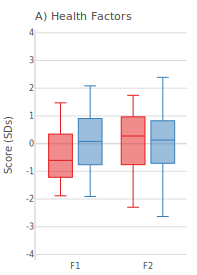

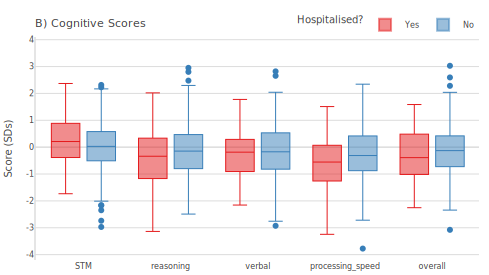

In [63]:
# Resets the plot layout options to my defaults
importlib.reload(wp)
w1 = 50
w2 = 174-w1

wp.rc_layout.update(
	width=wp.mm_to_pts(w1, dpi=1000), 
	boxgroupgap = .2,
	showlegend = False,
)

wp.rc_title.update(text = 'A) Health Factors')
hosp_hf_plots = wp.raincloud_plot(
	Zcc, fnames, 'hospital_stay', grp_order=['Yes', 'No'],
	grp_colours = plotly.colors.qualitative.Set1,
	do_vio = False, do_pts = False, sym_constant=True, sym_offset=1,
	box_args = {'boxpoints': 'outliers'},
)
save_and_display_figure(hosp_hf_plots, 'Figure_4a')

wp.rc_layout.update(
	width = wp.mm_to_pts(w2, dpi=1000),
	showlegend = True,
)

wp.rc_legend.update(
	title = 'Hospitalised?',
	xanchor = 'right', yanchor = 'bottom', x = 1, y = 0.99,
)

wp.rc_title.update(text = 'B) Cognitive Scores')
hosp_cog_plots = wp.raincloud_plot(
	Zcc, comp_scores, 'hospital_stay', grp_order=['Yes', 'No'],
	grp_colours = plotly.colors.qualitative.Set1,
	do_vio = False, do_pts = False, sym_constant=True, sym_offset=1,
	box_args = {'boxpoints': 'outliers'},
)
save_and_display_figure(hosp_cog_plots, 'Figure_4b')

 ### Directly Compare Non-/Hospitalised Groups
 Description here...


In [64]:
# Two-sample t-tests and stats
r7_ttests = (ws
	.two_sample_ttests('hospital_stay', comp_scores+fnames, Zcc, n_comparisons=7)
	.droplevel('contrast')
	.rename(columns={'cohen-d': 'd'})
)

save_and_display_table(r7_ttests[ttest_columns], 'Table_S9')

,diff,tstat,df,p_adj,CI,BF10
score,,,,,,
STM,-0.181926,-1.57,86.14,0.847,"(-0.502, 0.138)",0.46
reasoning,0.325578,2.44,85.62,0.116,"(-0.042, 0.693)",2.40
verbal,0.128226,1.10,93.73,1.000,"(-0.192, 0.448)",0.26
processing_speed,0.286200,2.13,82.47,0.251,"(-0.084, 0.656)",1.23
overall,0.139218,1.10,82.10,1.000,"(-0.210, 0.488)",0.26
F1,0.501985,3.92,88.55,0.001,"(0.149, 0.855)",189.99
F2,-0.028983,-0.21,84.41,1.000,"(-0.412, 0.354)",0.15


 ### Compare Each Non-/Hospitalised Group to Controls

In [65]:
# Two-sample t-tests and stats, etc.
r8_ttests = {}
for grp, grp_data in Zcc.groupby('hospital_stay'):
	Zall = pd.concat([grp_data, Zctrl], keys=['CC', 'SS'], names=['study'])
	r8_ttests[grp] = (ws
		.two_sample_ttests('study', comp_scores, Zall, n_comparisons=10)
		.droplevel('contrast')
		.rename(columns={'cohen-d': 'd'})
	)
r8_ttests = pd.concat(r8_ttests.values(), axis=0, keys=r8_ttests.keys(), names=['hospital_stay'])

save_and_display_table(r8_ttests[ttest_columns], 'Table_S10')

 ### Include Hospitalisation Status in Regression Models
 It doesn't quite look like there are differences in cognitive scores between
 Non/Hopistalised groups (though, probably a power issue) - so what happens if
 we include hospitalisation as a regressor in our models? Given that our
 analysis does model comparison, this tells us if F1 explains any variation in
 cognitive scores *after* controlling for the effect(s) of hospitalisation and
 F2.


Model Expression: %s ~ F1+F2+hospital_stay


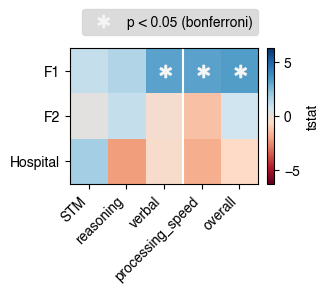

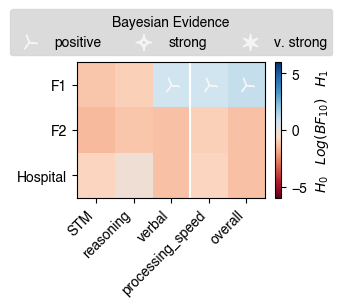

In [66]:
# Transform it into a binary variable, where 1 = "Yes" (hospitalised)
if Zcc.hospital_stay.dtype == 'category':
	Zcc.loc[:, 'hospital_stay'] = (
		OneHotEncoder(drop=['No'])
		.fit_transform(Zcc[['hospital_stay']])
		.todense()
	)

full_model_w_hosp = ws.build_model_expression(fnames, 'hospital_stay')
print(f"Model Expression: {full_model_w_hosp}")

rH_regressions, _ = ws.regression_analyses(
	full_model_w_hosp, comp_scores, Zcc, n_comparisons=15)

rH_comparisons = ws.compare_models([
	{'name': 'F1',
		'h0': ws.build_model_expression('F2', 'hospital_stay'), # without F1
		'h1': full_model_w_hosp}, 
	{'name': 'F2',
		'h0': ws.build_model_expression('F1', 'hospital_stay'), # without F1
		'h1': full_model_w_hosp},
	{'name': 'hospital_stay',
		'h0': ws.build_model_expression(fnames), # without hospital_stay
		'h1': full_model_w_hosp}
	], Zcc, comp_scores, smf.ols, n_comparisons=15)

resH_ = (rH_regressions
	.join(rH_comparisons.loc[:, comp_columns])
	.rename(columns={'value': 'B'})
	.loc[rH_comparisons.index, column_order]
	.rename({'hospital_stay': 'Hospital'})
)

save_and_display_table(resH_, 'Table_S11')

rH_t_fig = wp.create_stats_figure(
	resH_, 'tstat', 'p_adj', stat_range=[-6.3, 6.3],
	vertline=2, diverging=True, correction='bonferroni')
rH_b_fig = wp.create_bayes_factors_figure(
	resH_, suppress_h0=True, vertline=2)

rH_t_fig.savefig('./outputs/images/Figure_6a.svg')
rH_b_fig.savefig('./outputs/images/Figure_6b.svg')

 #%% [markdown]
# ## Other Exploratory Analyses

 ## Supplementary Analyses
 It might be informative to correlate each individual health-related variable,
 instead of factor scores, with the cosngitive scores. THen we can see if
 certain indicators are good predictors of cognitive performance,

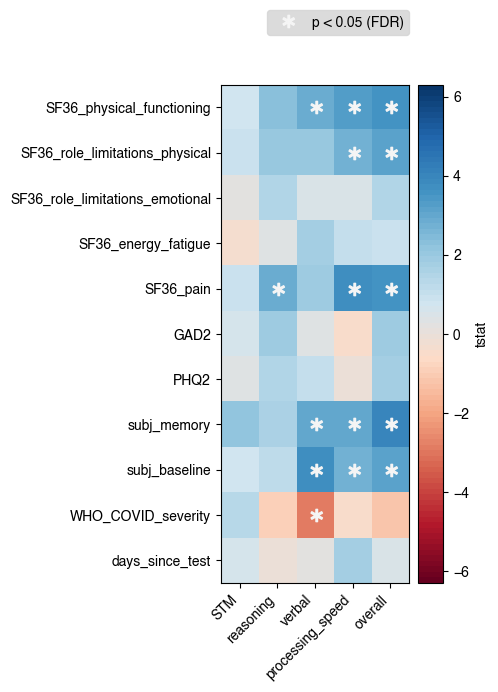

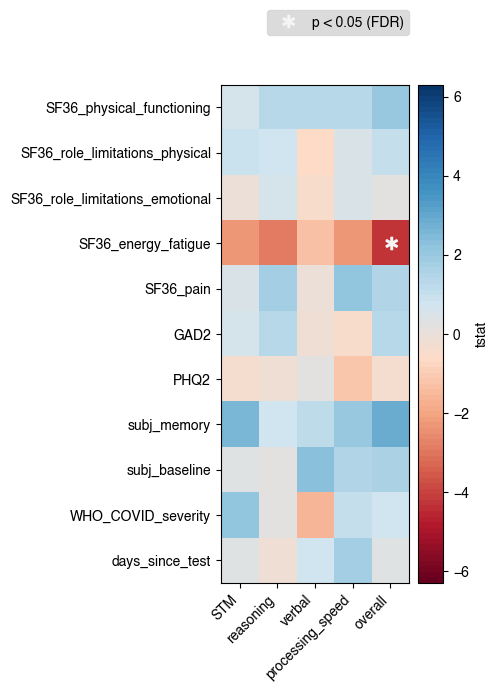

In [67]:
# 1st, we do simple pairwise correlations: 1 predictor in the model
health_vars = var_order #+ ['hospital_stay']
pairwise_data = Zcc[comp_scores+fnames+['hospital_stay']].join(fdata0, how='left')

p_adjustment = {'adj_across': 'all', 'adj_type': 'fdr_bh'}
rs1a = (pd
	.concat([ws.regression_analyses(f"%s ~ {var}", comp_scores, pairwise_data)[0] for var in health_vars])
	.drop('Intercept', level='contrast')
	.pipe(ws.adjust_pvals, **p_adjustment)
)

fs1a = wp.create_stats_figure(
	rs1a, 'tstat', 'p_adj', diverging=True, vertline=None,
	correction='FDR', stat_range=[-6.3, 6.3])

fs1a.savefig('./outputs/images/Figure_7a.svg')

# 2nd, enter all the variables into the same regression model then test each
# parameter separately.
model_exp = ws.build_model_expression(health_vars)
rs1b = (ws
	.regression_analyses(model_exp, comp_scores, pairwise_data)[0]
	.drop('Intercept', level='contrast')
	.pipe(ws.adjust_pvals, **p_adjustment)
)

fs1b = wp.create_stats_figure(
	rs1b, 'tstat', 'p_adj', diverging=True, vertline=None,
	correction='FDR', stat_range=[-6.3, 6.3])

fs1a.savefig('./outputs/images/Figure_7b.svg')

 ### Nuisance Variables
 Do any of the socio-demographic or other variables that we adjusted our
 dependent variables (cognitive scores) for show any residual association
 with the DVss

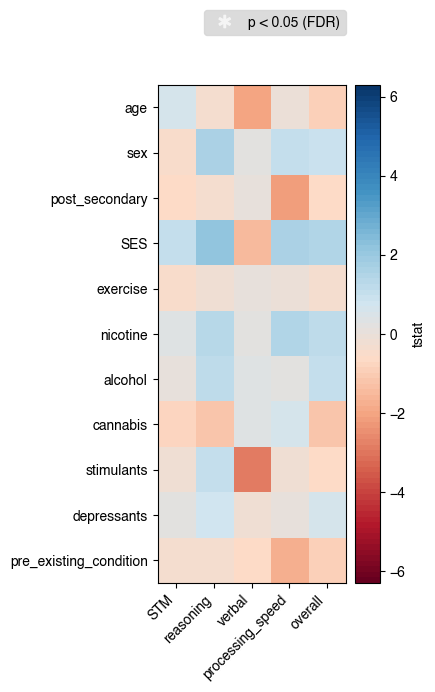

In [68]:
IVs =  Xcovar + ['pre_existing_condition']

Zcc_ = Zcc.copy()
Zcc_[Xcovar] = Xtfm_.transform(Zcc_[Xcovar])
Zcc_['pre_existing_condition'] = Zcc_['pre_existing_condition'].astype('int')

rs2 = (pd
	.concat([ws.regression_analyses(f"%s ~ {var}", comp_scores, Zcc_)[0] for var in IVs])
	.drop('Intercept', level='contrast')
	.pipe(ws.adjust_pvals, adj_across='all', adj_type='fdr_bh')
)

fs2 = wp.create_stats_figure(
	rs2, 'tstat', 'p_adj', diverging=True, vertline=None,
	correction='FDR', stat_range=[-6.3, 6.3])

fs2.savefig('./outputs/images/Figure_7b.svg')

 ### Sankey Diagram
 - This needs to be seriously cleaned up
 - Shows the flow of participants though questionnaire
 - Groups by assigned WHO COVID severity score

In [69]:
import itertools

groupers = ['symptoms',
			'hospital_stay', 'supplemental_O2_hospital',
			'ICU_stay',
			'ventilator', 'daily_routine', 'WHO']

q2 = Qcc.loc[Zcc.index, groupers].copy()
q2['WHO'] = q2['WHO'].astype('category')
q2['WHO'] = q2['WHO'].cat.add_categories('NA')
q2 = q2.fillna('NA')
q2.symptoms = q2.symptoms.astype('category')

q2 = remove_unused_categories(q2)

opts = [list(q2[g].cat.categories) for g in groupers]

all_paths = list(itertools.product(*opts))

src = []
trg = []
cnt = []
lab = []
for i, p in enumerate(all_paths):
	cnt.append((q2[groupers] == p).all(axis=1).sum())

good_i = [i for i, count in enumerate(cnt) if count > 0]
good_paths = [all_paths[i] for i in good_i]

p_ = []
for p in good_paths:
	lab.append(q2[(q2[groupers] == p).all(axis=1)]['WHO'].describe().top)
	p_.append(q2[(q2[groupers] == p).all(axis=1)])

good_cnts = [cnt[i] for i in good_i]

cats = CC.questionnaire.WHO_cats
ncat = len(cats)


links = {'source': [], 'target': [], 'value': []}
j = 0
for j, p in enumerate(good_paths):
	for i,v in enumerate(p[:-1]):
		if p[i] != "NA":
			ti = i+1
			while ti < (len(p)-1) and p[ti] == "NA":
				ti += 1
			if p[ti] != "NA":
				src = f"{groupers[i]}_{p[i]}"
				trg = f"{groupers[ti]}_{p[ti]}"
				links['source'].append(src)
				links['target'].append(trg)
				links['value'].append(good_cnts[j])

from floweaver import *

cats = CC.questionnaire.WHO_cats
ncat = len(cats)

import matplotlib
colormap = matplotlib.colors.ListedColormap(plotly.colors.sequential.Plasma)
colors = colormap(np.linspace(0, 1, ncat))
colors[:, -1] = 0.1

colors = [matplotlib.colors.to_hex(c) for c in colors]
colormap = dict(zip(cats, colors[0:ncat]))

links = pd.DataFrame(good_paths, columns=groupers)
links['value'] = good_cnts
links = links.rename(columns={'symptoms': 'source', 'WHO': 'target'})
links[links=='NA'] = np.nan

target = Partition.Simple('target', CC.questionnaire.WHO_cats)

nodes = {
	'start': ProcessGroup([False, True], Partition.Simple('source', [False, True]), title='Symptoms'),
	'end': ProcessGroup(CC.questionnaire.WHO_cats, target, title='COVID Severity'),
	'hospital': Waypoint(Partition.Simple('hospital_stay', ['No', 'Yes']), title='Hospitalised'),
	'daily': Waypoint(Partition.Simple('daily_routine', ['Yes', 'No']), title='Functional'),
	'o2': Waypoint(Partition.Simple('supplemental_O2_hospital', ['No', 'Yes', "Don't Know"]), title='Supplemental O2'),
	'ICU': Waypoint(Partition.Simple('ICU_stay', ['No', 'Yes']), title='ICU'),
	'ventilator': Waypoint(Partition.Simple('ventilator', ['No', 'Yes']), title='Ventilator'),
}

order = [
	['start'],
	['hospital'],
	['o2'],
	['daily', 'ICU'],
	['ventilator'],
	['end']
]

bundles = [
	# Bundle('start', 'end', waypoints=['hospital', 'ICU'], flow_selection="(hospital_stay == 'Yes')"),
	Bundle('start', 'end', waypoints=['hospital', 'daily'], flow_selection="(hospital_stay == 'No')"),
	Bundle('start', 'end', waypoints=['hospital', 'o2', 'ICU', 'ventilator'], flow_selection="(ICU_stay == 'Yes')"),
	Bundle('start', 'end', waypoints=['hospital', 'o2', 'ICU'], flow_selection="(ICU_stay == 'No')"),
]

In [70]:
sdd = SankeyDefinition(nodes, bundles, order, flow_partition=target)
(weave(sdd, links, palette=colormap)
	.to_widget(width=1000, align_link_types=True)
	.auto_save_svg('./outputs/images/Figure_S1.svg'))

SankeyWidget(align_link_types=True, groups=[{'id': 'start', 'type': 'process', 'title': 'Symptoms', 'nodes': […

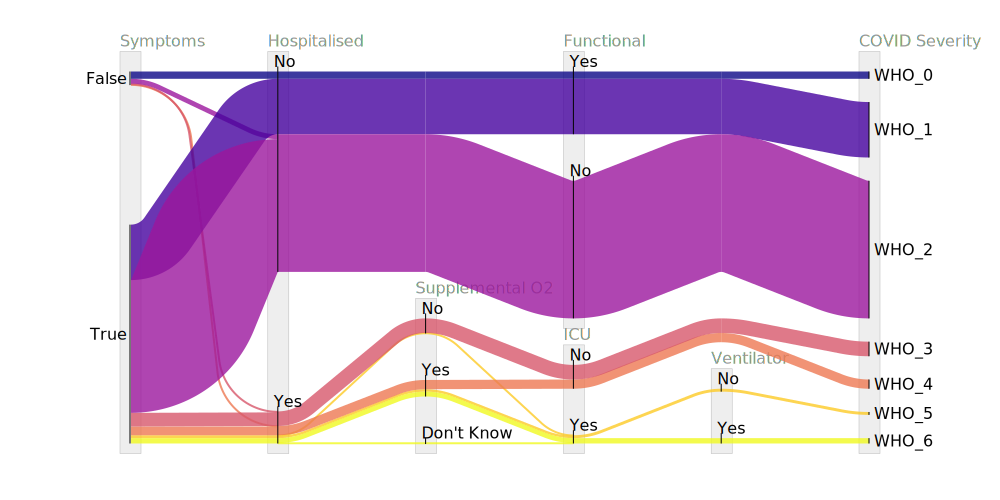

In [71]:
SVG('./outputs/images/Figure_S1.svg')

 Last updated 2022-03-01 by cwild